# National Data Science Bowl - Plankton

## Action Plan

* Make overfitting model
* Data augmentation
* Batch normalization
* Dropout
* Ensembling

## Imports and Directories

In [1]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
SCRIPTS_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

In [2]:
#import modules
from utils import *
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)
Using Theano backend.


In [3]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/nathan/git/planktonDataScienceBowl/scripts/data


## VGG Like Model

#### Constants

In [4]:
img_rows, img_cols = 128, 128
in_shape = (img_rows, img_cols)
batch_size = 64
nb_classes = 121

#### Batches

In [5]:
gen = image.ImageDataGenerator(rescale=1. / 255)
# gen = image.ImageDataGenerator()

In [6]:
train_batches = get_batches(train_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=gen)
val_batches   = get_batches(valid_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=gen)

Found 27184 images belonging to 121 classes.
Found 3152 images belonging to 121 classes.


#### Model

In [7]:
def get_model():
    model = Sequential([
        Convolution2D(64,3,3, border_mode='same', activation='relu', input_shape=(1, img_rows, img_cols)),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(256,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(nb_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = get_model()

In [9]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 128, 128)  640         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 128, 128)  36928       convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 64, 64, 64)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 128, 64, 64)   73856       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

#### Train

In [ ]:
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=5,
                    validation_data=val_batches,
                    nb_val_samples=val_batches.nb_sample,
                    verbose=True)

Epoch 1/5
 3776/27184 [===>..........................] - ETA: 95s - loss: 4.0138 - acc: 0.1205

In [ ]:
model.optimizer.lr=0.1
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=True)

In [ ]:
model.optimizer.lr=0.01
model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    nb_epoch=4,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    verbose=True)

## Data Augmentation

#### Constants

In [4]:
img_rows, img_cols = 128, 128
in_shape = (img_rows, img_cols)
batch_size = 64
nb_classes = 121
mean_px = 0.046544086
std_px = 0.15035126

#### Batches

In [5]:
batch_gen = image.ImageDataGenerator(
                rotation_range=360,
                width_shift_range=0.03,
                height_shift_range=0.03,
                shear_range=0.10,
                zoom_range=0.10,
                rescale=1. / 255,
                horizontal_flip = True,
                vertical_flip = True)

valid_gen = image.ImageDataGenerator(
#                                      featurewise_center=True,
#                                      featurewise_std_normalization=True,
                                     rescale=1. / 255
                                    )

In [6]:
train_batches = get_batches(train_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=batch_gen)
val_batches   = get_batches(valid_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=valid_gen)

Found 27184 images belonging to 121 classes.
Found 3152 images belonging to 121 classes.


#### Model

In [7]:
def norm_input(x): 
    return x
    return (x-mean_px)/(std_px)

In [10]:
def get_model():
    model = Sequential([
#         Convolution2D(64,3,3, border_mode='same', activation='relu', input_shape=(1, img_rows, img_cols)),
        Lambda(norm_input, input_shape=(1, img_rows, img_cols), output_shape=(1, img_rows, img_cols)),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(256,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(2048, activation='relu'),
        Dense(nb_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model = get_model()

/home/nathan/anaconda3/envs/deepLearning/lib/python3.5/site-packages/keras/engine/topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_2_model" was not an Input tensor, it was generated by layer lambda_2.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_2
  str(x.name))


In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 1, 128, 128)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 64, 128, 128)  640         lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 64, 128, 128)  36928       convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 64, 64, 64)    0           convolution2d_6[0][0]            
___________________________________________________________________________________________

#### Train

In [ ]:
history = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=25, verbose=True)

Epoch 1/25
27184/27184 [==============================] - 115s - loss: 2.7705 - acc: 0.2926 - val_loss: 2.1929 - val_acc: 0.3871
Epoch 2/25
27184/27184 [==============================] - 114s - loss: 1.9655 - acc: 0.4385 - val_loss: 1.7786 - val_acc: 0.4759
Epoch 3/25
 6912/27184 [======>.......................] - ETA: 84s - loss: 1.7519 - acc: 0.4848

In [22]:
model.save_weights('last_attempt_augmentation.h5')

#### Visualize Training

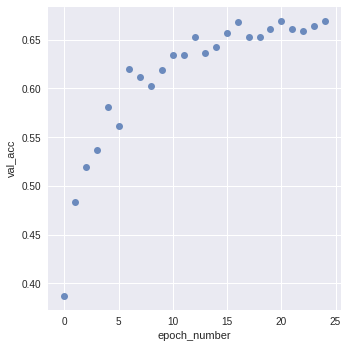

In [24]:
df = pd.DataFrame(history.history)
df['epoch_number'] = range(len(df))
sns.lmplot(x="epoch_number", y="val_acc", data=df, fit_reg=False)

## Data Augmentation + Batch Normalization

#### Constants

In [4]:
img_rows, img_cols = 128, 128
in_shape = (img_rows, img_cols)
batch_size = 64
nb_classes = 121
mean_px = 0.046544086
std_px = 0.15035126

#### Batches

In [5]:
batch_gen = image.ImageDataGenerator(
                rotation_range=360,
                width_shift_range=0.03,
                height_shift_range=0.03,
                shear_range=0.10,
                zoom_range=0.10,
                rescale=1. / 255,
                horizontal_flip = True,
                vertical_flip = True)

valid_gen = image.ImageDataGenerator(
                                     rescale=1. / 255
                                    )

In [6]:
train_batches = get_batches(train_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=batch_gen)
val_batches   = get_batches(valid_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=valid_gen)

Found 27184 images belonging to 121 classes.
Found 3152 images belonging to 121 classes.


#### Model

In [7]:
def norm_input(x): return (x-mean_px)/(std_px)

In [8]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1, img_rows, img_cols), output_shape=(1, img_rows, img_cols)),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(256,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dense(nb_classes, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = get_model()

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 1, 128, 128)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 128, 128)  640         lambda_1[0][0]                   
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 64, 128, 128)  256         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 128, 128)  36928       batchnormalization_1[0][0]       
___________________________________________________________________________________________

#### Train

In [11]:
def update_history(old, new):
    for key, value in new.history.items():
        old.history[key] = (old.history[key] + value)
    return old

In [12]:
history = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=30, verbose=True)

Epoch 1/30
27184/27184 [==============================] - 132s - loss: 3.0283 - acc: 0.3131 - val_loss: 8.0631 - val_acc: 0.0660
Epoch 2/30
27184/27184 [==============================] - 144s - loss: 2.3078 - acc: 0.4186 - val_loss: 2.6403 - val_acc: 0.3604
Epoch 3/30
27184/27184 [==============================] - 135s - loss: 2.1343 - acc: 0.4505 - val_loss: 3.2266 - val_acc: 0.2897
Epoch 4/30
27184/27184 [==============================] - 144s - loss: 1.9885 - acc: 0.4663 - val_loss: 2.7592 - val_acc: 0.3296
Epoch 5/30
27184/27184 [==============================] - 143s - loss: 1.8535 - acc: 0.4946 - val_loss: 1.7695 - val_acc: 0.5016
Epoch 6/30
27184/27184 [==============================] - 134s - loss: 1.8714 - acc: 0.4982 - val_loss: 2.2544 - val_acc: 0.4277
Epoch 7/30
27184/27184 [==============================] - 134s - loss: 1.7590 - acc: 0.5247 - val_loss: 7.0555 - val_acc: 0.1307
Epoch 8/30
27184/27184 [==============================] - 136s - loss: 1.6618 - acc: 0.5376 - val

In [19]:
model.optimizer.lr=0.00001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=5, verbose=True)
history = update_history(history, history_new)

Epoch 1/5
27184/27184 [==============================] - 185s - loss: 0.8349 - acc: 0.7219 - val_loss: 3.2147 - val_acc: 0.4188
Epoch 2/5
27184/27184 [==============================] - 185s - loss: 0.8113 - acc: 0.7238 - val_loss: 2.0126 - val_acc: 0.5266
Epoch 3/5
27184/27184 [==============================] - 185s - loss: 0.7950 - acc: 0.7298 - val_loss: 1.8864 - val_acc: 0.5698
Epoch 4/5
27184/27184 [==============================] - 185s - loss: 0.7836 - acc: 0.7316 - val_loss: 5.8026 - val_acc: 0.3106
Epoch 5/5
27184/27184 [==============================] - 185s - loss: 0.7755 - acc: 0.7332 - val_loss: 1.4031 - val_acc: 0.6459


In [41]:
model.optimizer.lr=0.000001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=1, verbose=True)
history = update_history(history, history_new)

Epoch 1/1
27184/27184 [==============================] - 316s - loss: 4.2346 - acc: 0.1007 - val_loss: 3.9503 - val_acc: 0.1497


NameError: name 'history' is not defined

In [ ]:
model.optimizer.lr=0.0000001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=100, verbose=True)
history = update_history(history, history_new)

In [11]:
# history = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
#                     validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
#                     nb_epoch=30, verbose=True)

Epoch 1/30
27184/27184 [==============================] - 168s - loss: 3.0107 - acc: 0.3190 - val_loss: 9.7742 - val_acc: 0.0853
Epoch 2/30
27184/27184 [==============================] - 171s - loss: 2.3195 - acc: 0.4146 - val_loss: 3.2141 - val_acc: 0.3220
Epoch 3/30
27184/27184 [==============================] - 178s - loss: 1.9687 - acc: 0.4579 - val_loss: 2.6561 - val_acc: 0.3791
Epoch 4/30
27184/27184 [==============================] - 169s - loss: 1.7481 - acc: 0.4985 - val_loss: 2.0476 - val_acc: 0.4213
Epoch 5/30
27184/27184 [==============================] - 162s - loss: 1.6184 - acc: 0.5283 - val_loss: 3.5724 - val_acc: 0.2582
Epoch 6/30
27184/27184 [==============================] - 161s - loss: 1.5127 - acc: 0.5539 - val_loss: 2.4700 - val_acc: 0.3731
Epoch 7/30
27184/27184 [==============================] - 162s - loss: 1.4419 - acc: 0.5693 - val_loss: 2.9279 - val_acc: 0.2947
Epoch 8/30
27184/27184 [==============================] - 162s - loss: 1.3834 - acc: 0.5777 - val

In [21]:
model.save_weights('last_attempt_batch_norm.h5')

#### Visualize Training

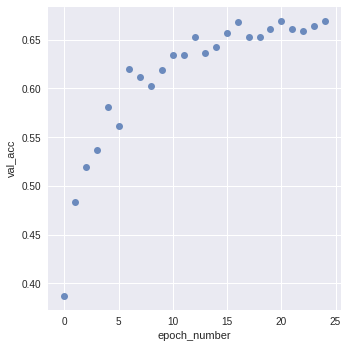

In [24]:
df = pd.DataFrame(history.history)
df['epoch_number'] = range(len(df))
sns.lmplot(x="epoch_number", y="val_acc", data=df, fit_reg=False)

## Data Augmentation + Batch Normalization + Dropout

#### Constants

In [4]:
img_rows, img_cols = 128, 128
in_shape = (img_rows, img_cols)
batch_size = 64
nb_classes = 121
mean_px = 0.046544086
std_px = 0.15035126

#### Batches

In [5]:
batch_gen = image.ImageDataGenerator(
                rotation_range=360,
                width_shift_range=0.03,
                height_shift_range=0.03,
                shear_range=0.10,
                zoom_range=0.10,
                rescale=1. / 255,
                horizontal_flip = True,
                vertical_flip = True)

valid_gen = image.ImageDataGenerator(
#                                      featurewise_center=True,
#                                      featurewise_std_normalization=True,
                                     rescale=1. / 255
                                    )

In [6]:
train_batches = get_batches(train_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=batch_gen)
val_batches   = get_batches(valid_path, batch_size=batch_size, 
                            target_size=in_shape, color_mode="grayscale", 
                            gen=valid_gen)

Found 27184 images belonging to 121 classes.
Found 3152 images belonging to 121 classes.


#### Model

In [7]:
def norm_input(x): return (x-mean_px)/(std_px)

In [8]:
def get_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1, img_rows, img_cols), output_shape=(1, img_rows, img_cols)),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(256,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(nb_classes, activation='softmax')
        ])
    model.compile(Adam(decay=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = get_model()

/home/nathan/anaconda3/envs/deepLearning/lib/python3.5/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 128, 128)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 1, 128, 128)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 128, 128)  640         lambda_1[0][0]                   
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 64, 128, 128)  256         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 128, 128)  36928       batchnormalization_1[0][0]       
___________________________________________________________________________________________

#### Train

In [11]:
def update_history(old, new):
    for key, value in new.history.items():
        old.history[key] = (old.history[key] + value)
    return old

In [12]:
history = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=300, verbose=True)

Epoch 1/30
27184/27184 [==============================] - 166s - loss: 3.2261 - acc: 0.2921 - val_loss: 10.9946 - val_acc: 0.0774
Epoch 2/30
27184/27184 [==============================] - 162s - loss: 2.5152 - acc: 0.3885 - val_loss: 2.7048 - val_acc: 0.3334
Epoch 3/30
27184/27184 [==============================] - 161s - loss: 2.2480 - acc: 0.4311 - val_loss: 2.9879 - val_acc: 0.3096
Epoch 4/30
27184/27184 [==============================] - 162s - loss: 2.0946 - acc: 0.4570 - val_loss: 3.5947 - val_acc: 0.1846
Epoch 5/30
27184/27184 [==============================] - 162s - loss: 1.9956 - acc: 0.4674 - val_loss: 4.2786 - val_acc: 0.2116
Epoch 6/30
27184/27184 [==============================] - 162s - loss: 1.9011 - acc: 0.4946 - val_loss: 2.7187 - val_acc: 0.3293
Epoch 7/30
27184/27184 [==============================] - 165s - loss: 1.7281 - acc: 0.5108 - val_loss: 2.6375 - val_acc: 0.4026
Epoch 8/30
27184/27184 [==============================] - 167s - loss: 1.6054 - acc: 0.5356 - va

In [13]:
model.save_weights('last_attempt_dropout.h5')

In [14]:
model.optimizer.lr=0.001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=5, verbose=True)
history = update_history(history, history_new)

Epoch 1/5
27184/27184 [==============================] - 168s - loss: 1.0591 - acc: 0.6651 - val_loss: 2.6359 - val_acc: 0.4648
Epoch 2/5
27184/27184 [==============================] - 165s - loss: 1.0710 - acc: 0.6661 - val_loss: 7.6091 - val_acc: 0.1742
Epoch 3/5
27184/27184 [==============================] - 162s - loss: 1.0390 - acc: 0.6671 - val_loss: 1.4861 - val_acc: 0.6269
Epoch 4/5
27184/27184 [==============================] - 163s - loss: 1.0293 - acc: 0.6702 - val_loss: 1.4595 - val_acc: 0.6310
Epoch 5/5
27184/27184 [==============================] - 161s - loss: 1.0618 - acc: 0.6632 - val_loss: 3.1094 - val_acc: 0.4201


In [15]:
model.optimizer.lr=0.0001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=5, verbose=True)
history = update_history(history, history_new)

Epoch 1/5
27184/27184 [==============================] - 162s - loss: 1.0368 - acc: 0.6707 - val_loss: 1.3661 - val_acc: 0.6301
Epoch 2/5
27184/27184 [==============================] - 162s - loss: 1.0116 - acc: 0.6753 - val_loss: 1.4064 - val_acc: 0.6666
Epoch 3/5
 8256/27184 [========>.....................] - ETA: 110s - loss: 0.9586 - acc: 0.6846

KeyboardInterrupt: 

In [ ]:
model.optimizer.lr=0.00001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=5, verbose=True)
history = update_history(history, history_new)

In [ ]:
model.optimizer.lr=0.000001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=5, verbose=True)
history = update_history(history, history_new)

In [ ]:
model.optimizer.lr=0.0000001
history_new = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=5, verbose=True)
history = update_history(history, history_new)

#### Visualize Training

In [ ]:
df = pd.DataFrame(history.history)
df['epoch_number'] = range(len(df))
sns.lmplot(x="epoch_number", y="val_acc", data=df, fit_reg=False)

#### Try out different learning rates below

So far it looks like the validation accuracy is jumping around like crazy while the training accuracy keeps going up. This can be from two possible reasons:
*  Learning rate is too high
*  Need dropout (overfitting really hard)

In [13]:
# model.save_weights('keep_lowering_learning_rate.h5')

In [14]:
model.load_weights('keep_lowering_learning_rate.h5')

In [15]:
model.optimizer.lr=0.000001
history2 = model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                    nb_epoch=3, verbose=True)

Epoch 1/3
27184/27184 [==============================] - 184s - loss: 0.5837 - acc: 0.7977 - val_loss: 1.3196 - val_acc: 0.6878
Epoch 2/3
27184/27184 [==============================] - 185s - loss: 0.5793 - acc: 0.8005 - val_loss: 1.3142 - val_acc: 0.6859
Epoch 3/3
27184/27184 [==============================] - 186s - loss: 0.5706 - acc: 0.8005 - val_loss: 1.3022 - val_acc: 0.6938


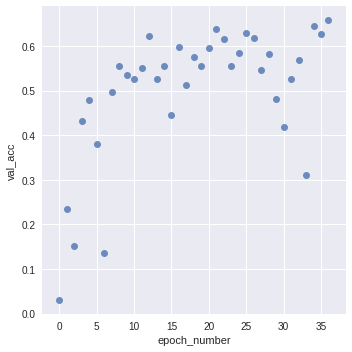

In [22]:
df = pd.DataFrame(history.history)
df['epoch_number'] = range(len(df))
sns.lmplot(x="epoch_number", y="val_acc", data=df, fit_reg=False)

## Ensembling 